## 01. Imports & CSV upload

In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os
from datetime import datetime
import time
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# --- Plotting style ---
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- Logging setup ---
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# --- Expected schema (v2) ---
EXPECTED_FIELDS = [
    "asset_id", "asset_type", "location", "region", "urban_type",
    "size_m2", "rooms", "bathrooms", "year_built", "age_years",
    "floor", "building_floors", "has_elevator", "has_garden",
    "has_balcony", "garage", "owner_occupied", "public_transport_nearby",
    "distance_to_center_km", "energy_class", "humidity_level",
    "temperature_avg", "noise_level", "air_quality_index",
    "luxury_score", "env_score", "price_per_sqm", "valuation_k",
    "condition_score", "risk_score", "last_verified_ts"
]

# --- Load dataset ---
DATA_PATH = "../data/property_dataset_v2.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

# --- Add prediction timestamp if missing ---
if "prediction_ts" not in df.columns:
    df["prediction_ts"] = datetime.utcnow().isoformat()
    logging.info("⏱️  Added prediction_ts column")

# --- Preview essential columns ---
df[[
    "asset_type", "condition_score", "risk_score",
    "last_verified_ts", "prediction_ts", "luxury_score", "env_score"
]].head()

2025-07-29 03:54:24,858 [INFO] ⏱️  Added prediction_ts column


,asset_type,condition_score,risk_score,last_verified_ts,prediction_ts,luxury_score,env_score
0,property,0.798,0.183,2025-06-01T08:47:52Z,2025-07-29T01:54:24.856697,0.6,0.6
1,property,0.611,0.401,2025-06-13T05:08:52Z,2025-07-29T01:54:24.856697,0.4,0.4
2,property,0.659,0.363,2025-06-14T12:31:52Z,2025-07-29T01:54:24.856697,0.2,0.7
3,property,0.772,0.221,2025-07-06T06:36:52Z,2025-07-29T01:54:24.856697,0.6,0.7
4,property,0.640,0.328,2025-06-05T05:13:52Z,2025-07-29T01:54:24.856697,0.0,0.3


## 02. Data Validation

In [3]:
def validate_loaded_data(df: pd.DataFrame) -> bool:
    """
    Validazione completa: schema, logica e qualità dei dati.
    """
    logging.info("📊 DATASET VALIDATION STARTED")

    # --- Schema check ---
    missing_fields = set(EXPECTED_FIELDS) - set(df.columns)
    if missing_fields:
        logging.error(f"❌ Missing fields: {missing_fields}")
    else:
        logging.info(f"✅ Schema completo: {len(df.columns)} colonne")

    checks = {}

    # --- Range checks ---
    for score_col in ["condition_score", "risk_score", "luxury_score", "env_score"]:
        if score_col in df.columns:
            invalid_count = (~df[score_col].between(0, 1)).sum()
            checks[f"valid_{score_col}"] = invalid_count == 0
            if invalid_count > 0:
                logging.warning(f"⚠️  {invalid_count} valori fuori range in '{score_col}'")

    # --- Logical constraints ---
    checks.update({
        "unique_asset_ids": df["asset_id"].is_unique,
        "floor_logic": (df["floor"] <= df["building_floors"]).all(),
        "positive_size": (df["size_m2"] > 0).all(),
        "positive_valuation": (df["valuation_k"] > 0).all(),
        "no_missing_critical": df[["asset_id", "asset_type", "valuation_k"]].notna().all().all(),
    })

    for check, result in checks.items():
        logging.info(f"{'✅' if result else '❌'} {check}")

    all_passed = all(checks.values()) and not missing_fields

    if all_passed:
        logging.info("✅ DATASET VALIDATION COMPLETED SUCCESSFULLY")
    else:
        logging.error("❌ DATASET VALIDATION FAILED")

    return all_passed


# --- Esegui validazione ---
is_valid = validate_loaded_data(df)
assert is_valid, "❌ Dataset validation failed!"

2025-07-29 03:54:26,351 [INFO] 📊 DATASET VALIDATION STARTED
2025-07-29 03:54:26,353 [INFO] ✅ Schema completo: 40 colonne
2025-07-29 03:54:26,360 [INFO] ✅ valid_condition_score
2025-07-29 03:54:26,361 [INFO] ✅ valid_risk_score
2025-07-29 03:54:26,361 [INFO] ✅ valid_luxury_score
2025-07-29 03:54:26,363 [INFO] ✅ valid_env_score
2025-07-29 03:54:26,364 [INFO] ✅ unique_asset_ids
2025-07-29 03:54:26,364 [INFO] ✅ floor_logic
2025-07-29 03:54:26,365 [INFO] ✅ positive_size
2025-07-29 03:54:26,365 [INFO] ✅ positive_valuation
2025-07-29 03:54:26,366 [INFO] ✅ no_missing_critical
2025-07-29 03:54:26,367 [INFO] ✅ DATASET VALIDATION COMPLETED SUCCESSFULLY


### Description statistics

In [4]:
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 5000 non-null   object 
 1   asset_type               5000 non-null   object 
 2   location                 5000 non-null   object 
 3   region                   5000 non-null   object 
 4   urban_type               5000 non-null   object 
 5   size_m2                  5000 non-null   int64  
 6   rooms                    5000 non-null   int64  
 7   bathrooms                5000 non-null   int64  
 8   year_built               5000 non-null   int64  
 9   age_years                5000 non-null   int64  
 10  floor                    5000 non-null   int64  
 11  building_floors          5000 non-null   int64  
 12  has_elevator             5000 non-null   int64  
 13  has_garden               5000 non-null   int64  
 14  has_balcony             

,asset_id,asset_type,location,region,urban_type,size_m2,rooms,bathrooms,year_built,age_years,...,price_per_sqm,quarter_built,decade_built,rooms_per_sqm,bathrooms_per_room,avg_room_size,location_premium,amenity_count,price_vs_region_avg,prediction_ts
count,5000,5000,5000,5000,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000
unique,5000,1,15,5,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,asset_0000,property,Bari,north,urban,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-29T01:54:24.856697
freq,1,5000,382,1917,2326,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000
mean,NaN,NaN,NaN,NaN,NaN,119.623000,3.982600,2.001600,1985.787200,39.212800,...,2481.938130,1.0,1981.430000,0.040183,0.582530,34.859200,1.066320,2.258000,1.000000,NaN
std,NaN,NaN,NaN,NaN,NaN,46.093381,1.419401,0.818371,21.190463,21.190463,...,673.261142,0.0,21.246774,0.025160,0.348808,20.281836,0.139848,0.887465,0.474328,NaN
min,NaN,NaN,NaN,NaN,NaN,40.000000,2.000000,1.000000,1950.000000,3.000000,...,1212.300000,1.0,1950.000000,0.010050,0.166667,6.666667,0.800000,0.000000,0.185889,NaN
25%,NaN,NaN,NaN,NaN,NaN,79.000000,3.000000,1.000000,1967.000000,21.000000,...,1902.325000,1.0,1960.000000,0.022388,0.333333,19.833333,1.000000,2.000000,0.624638,NaN
50%,NaN,NaN,NaN,NaN,NaN,121.000000,4.000000,2.000000,1986.000000,39.000000,...,2495.825000,1.0,1980.000000,0.033333,0.500000,30.000000,1.000000,2.000000,0.910457,NaN
75%,NaN,NaN,NaN,NaN,NaN,159.000000,5.000000,3.000000,2004.000000,58.000000,...,3052.957500,1.0,2000.000000,0.050420,0.750000,44.666667,1.200000,3.000000,1.319978,NaN


<Axes: >

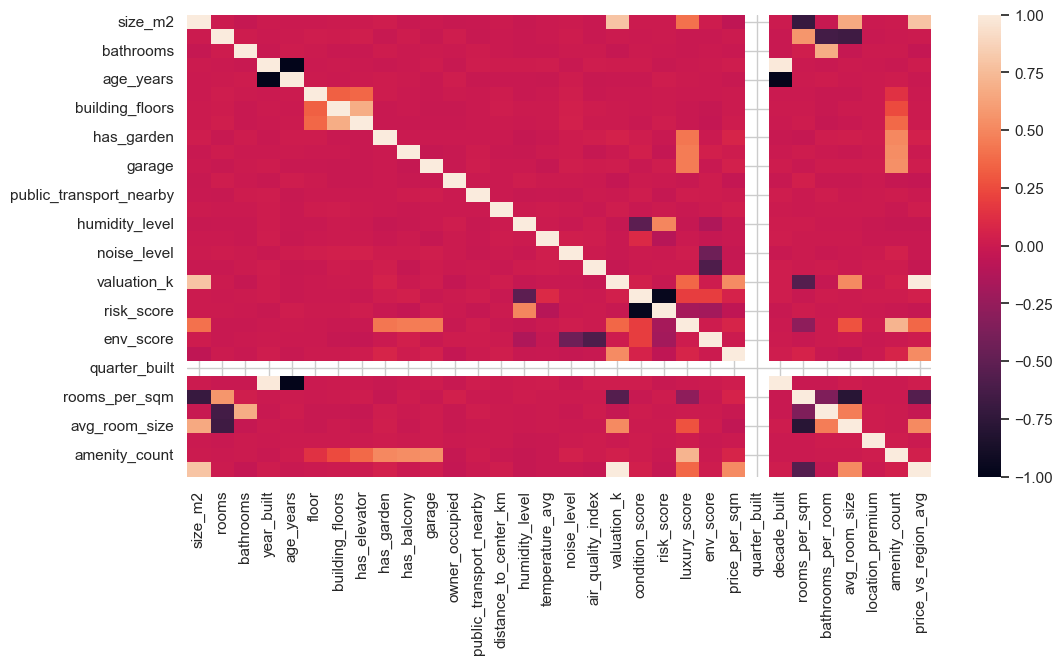

In [5]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
sns.heatmap(corr)

## 03. Key Fields

In [6]:
logging.info(f"Shape: {df.shape}")
logging.info("\nMissing values:\n%s", df.isnull().sum())
logging.info("\nAsset Types Distribution:\n%s", df["asset_type"].value_counts())

2025-07-29 03:54:29,613 [INFO] Shape: (5000, 40)
2025-07-29 03:54:29,617 [INFO] 
Missing values:
asset_id                   0
asset_type                 0
location                   0
region                     0
urban_type                 0
size_m2                    0
rooms                      0
bathrooms                  0
year_built                 0
age_years                  0
floor                      0
building_floors            0
has_elevator               0
has_garden                 0
has_balcony                0
garage                     0
owner_occupied             0
public_transport_nearby    0
distance_to_center_km      0
energy_class               0
humidity_level             0
temperature_avg            0
noise_level                0
air_quality_index          0
valuation_k                0
condition_score            0
risk_score                 0
luxury_score               0
env_score                  0
last_verified_ts           0
price_per_sqm              0
quar

In [7]:
def profile_dataset_performance(df: pd.DataFrame) -> dict:
    """Analizza utilizzo memoria, tipi, e performance base."""
    import time
    
    results = {}

    # --- Memoria ---
    mem_mb = df.memory_usage(deep=True).sum() / 1024**2
    results['memory_mb'] = round(mem_mb, 2)
    logging.info(f"📦 Memory usage: {results['memory_mb']} MB")

    # --- Groupby di test ---
    start = time.time()
    _ = df.groupby(['location', 'energy_class'])['valuation_k'].mean()
    groupby_time = (time.time() - start) * 1000
    results['groupby_time_ms'] = round(groupby_time, 2)
    logging.info(f"⏱️ GroupBy time: {results['groupby_time_ms']} ms")

    # --- Suggerimenti tipi ---
    results['dtype_optimization'] = {}
    for col in df.select_dtypes(include=['int64']).columns:
        min_val, max_val = df[col].min(), df[col].max()
        if min_val >= 0 and max_val < 255:
            results['dtype_optimization'][col] = 'uint8'
        elif max_val < 65535:
            results['dtype_optimization'][col] = 'uint16'

    if results['dtype_optimization']:
        logging.info("🔧 Colonne ottimizzabili: %s", results['dtype_optimization'])

    # --- Colonne suggerite per indice ---
    results['suggested_index'] = [
        col for col in ['location', 'energy_class', 'asset_id'] if col in df.columns
    ]
    logging.info(f"🔎 Suggest index on: {results['suggested_index']}")

    return results

# --- Esegui profiling ---
profiling_results = profile_dataset_performance(df)

2025-07-29 03:54:30,438 [INFO] 📦 Memory usage: 3.79 MB
2025-07-29 03:54:30,454 [INFO] ⏱️ GroupBy time: 14.99 ms
2025-07-29 03:54:30,457 [INFO] 🔧 Colonne ottimizzabili: {'size_m2': 'uint8', 'rooms': 'uint8', 'bathrooms': 'uint8', 'year_built': 'uint16', 'age_years': 'uint8', 'floor': 'uint8', 'building_floors': 'uint8', 'has_elevator': 'uint8', 'has_garden': 'uint8', 'has_balcony': 'uint8', 'garage': 'uint8', 'owner_occupied': 'uint8', 'public_transport_nearby': 'uint8', 'noise_level': 'uint8', 'air_quality_index': 'uint8', 'quarter_built': 'uint8', 'decade_built': 'uint16', 'amenity_count': 'uint8'}
2025-07-29 03:54:30,459 [INFO] 🔎 Suggest index on: ['location', 'energy_class', 'asset_id']


### Profiling

In [8]:
def apply_dtype_optimization(df: pd.DataFrame, optimizations: dict) -> pd.DataFrame:
    """Applica conversioni dtype suggerite."""
    for col, dtype in optimizations.items():
        try:
            df[col] = df[col].astype(dtype)
            logging.info(f"🔁 {col} convertito in {dtype}")
        except Exception as e:
            logging.warning(f"⚠️  Errore durante conversione {col} → {dtype}: {e}")
    return df

df = apply_dtype_optimization(df, profiling_results.get("dtype_optimization", {}))

2025-07-29 03:54:31,786 [INFO] 🔁 size_m2 convertito in uint8
2025-07-29 03:54:31,788 [INFO] 🔁 rooms convertito in uint8
2025-07-29 03:54:31,789 [INFO] 🔁 bathrooms convertito in uint8
2025-07-29 03:54:31,792 [INFO] 🔁 year_built convertito in uint16
2025-07-29 03:54:31,793 [INFO] 🔁 age_years convertito in uint8
2025-07-29 03:54:31,794 [INFO] 🔁 floor convertito in uint8
2025-07-29 03:54:31,796 [INFO] 🔁 building_floors convertito in uint8
2025-07-29 03:54:31,798 [INFO] 🔁 has_elevator convertito in uint8
2025-07-29 03:54:31,800 [INFO] 🔁 has_garden convertito in uint8
2025-07-29 03:54:31,801 [INFO] 🔁 has_balcony convertito in uint8
2025-07-29 03:54:31,802 [INFO] 🔁 garage convertito in uint8
2025-07-29 03:54:31,803 [INFO] 🔁 owner_occupied convertito in uint8
2025-07-29 03:54:31,804 [INFO] 🔁 public_transport_nearby convertito in uint8
2025-07-29 03:54:31,807 [INFO] 🔁 noise_level convertito in uint8
2025-07-29 03:54:31,809 [INFO] 🔁 air_quality_index convertito in uint8
2025-07-29 03:54:31,810 [

## 04. Categorical Data Analysis

In [9]:
# --- Distribuzione località ---
location_counts = df["location"].value_counts()
logging.info("\n🌍 Location distribution:\n%s", location_counts)

# --- Distribuzione classi energetiche ---
energy_order = ["A", "B", "C", "D", "E", "F", "G"]
energy_counts = df["energy_class"].value_counts().reindex(energy_order).fillna(0).astype(int)
energy_pct = (energy_counts / len(df) * 100).round(1)

logging.info("\n⚡ Energy classes distribution:\n%s", energy_counts)

# --- Tabella percentuali + conteggi ---
energy_df = pd.DataFrame({
    "count": energy_counts,
    "pct%": energy_pct
})
display(energy_df)

2025-07-29 03:54:39,613 [INFO] 
🌍 Location distribution:
location
Bari        382
Bologna     352
Palermo     350
Venice      347
Florence    345
Catania     338
Trieste     337
Genoa       332
Rome        332
Naples      331
Milan       327
Cagliari    321
Padua       313
Turin       307
Verona      286
Name: count, dtype: int64
2025-07-29 03:54:39,616 [INFO] 
⚡ Energy classes distribution:
energy_class
A    699
B    693
C    758
D    695
E    715
F    713
G    727
Name: count, dtype: int64


,count,pct%
energy_class,,
A,699,14.0
B,693,13.9
C,758,15.2
D,695,13.9
E,715,14.3
F,713,14.3
G,727,14.5


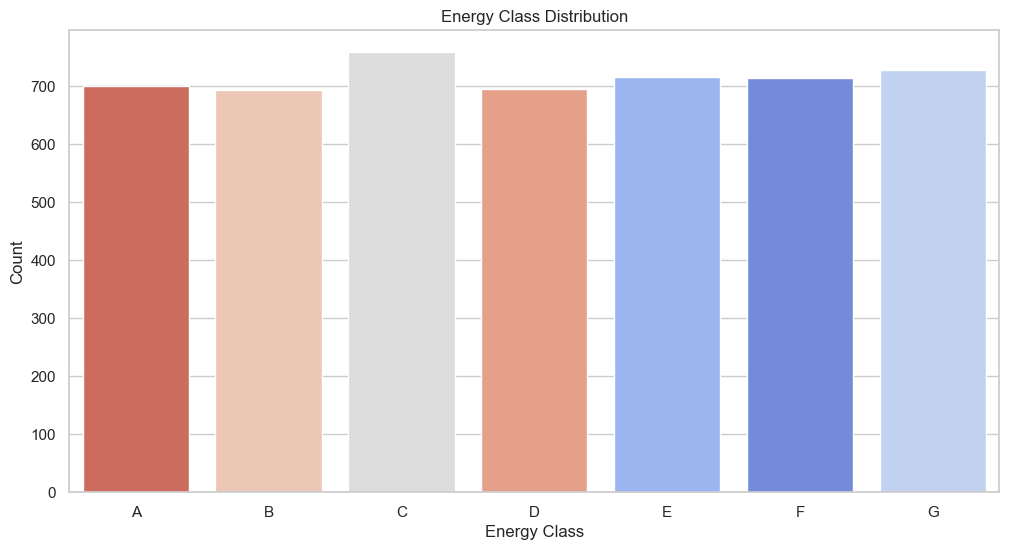

NameError: name 'top_locations' is not defined

In [10]:
# --- Plot: Distribuzione Classi Energetiche ---
sns.countplot(
    data=df, x="energy_class", hue="energy_class",
    order=energy_order,
    palette="coolwarm",
    legend=False
)
plt.title("Energy Class Distribution")
plt.xlabel("Energy Class")
plt.ylabel("Count")
plt.show()

# --- Plot: Top 10 Località (per leggibilità) ---
sns.countplot(
    data=df[df["location"].isin(top_locations)],
    y="location", hue="location",
    order=top_locations,
    palette="crest",
    legend=False
)
plt.title("Top 10 Location Distribution")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

## 05. Key distributions (size and value)

In [11]:
# --- Statistiche descrittive principali ---
logging.info("📈 Statistiche descrittive:\n%s", df[["size_m2", "valuation_k", "condition_score", "risk_score"]].describe())

2025-07-29 03:54:41,493 [INFO] 📈 Statistiche descrittive:
           size_m2  valuation_k  condition_score   risk_score
count  5000.000000  5000.000000      5000.000000  5000.000000
mean    119.623000   294.981854         0.779011     0.220679
std      46.093381   139.975732         0.073069     0.075932
min      40.000000    54.780000         0.477000     0.021000
25%      79.000000   183.707500         0.734000     0.164000
50%     121.000000   268.655000         0.788500     0.212000
75%     159.000000   390.037500         0.833250     0.269000
max     199.000000   719.270000         0.935000     0.545000


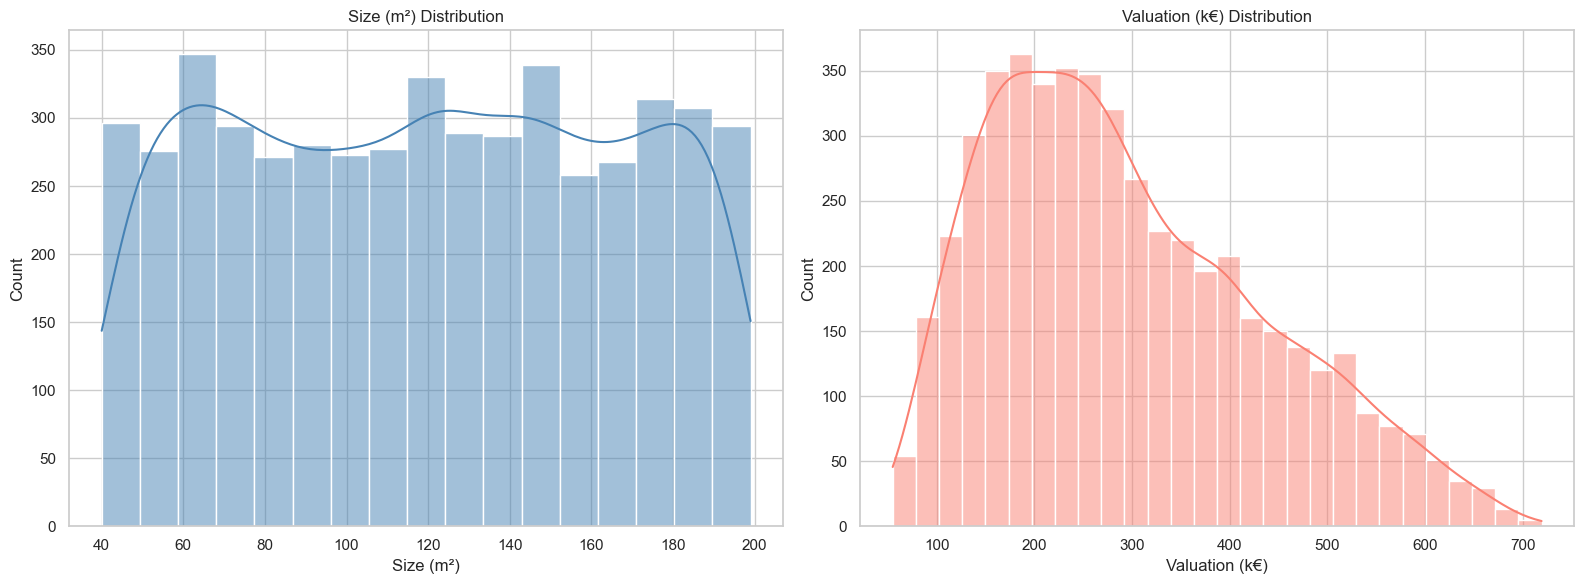

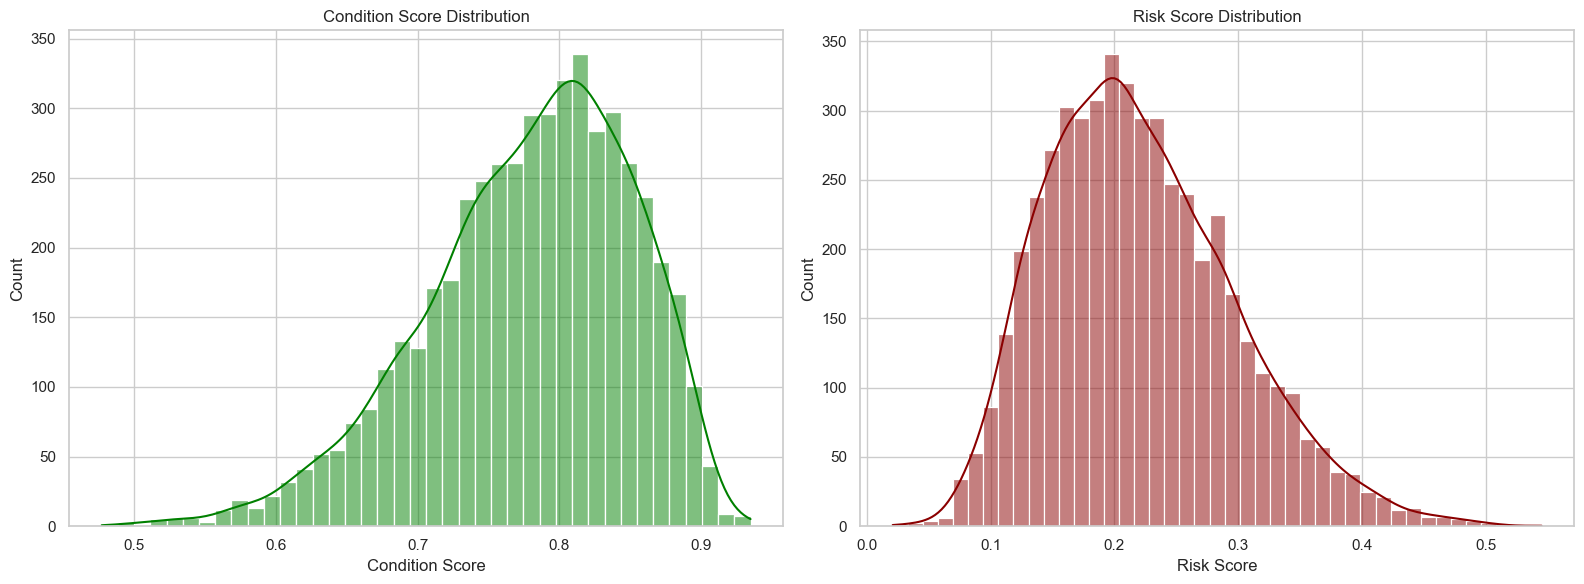

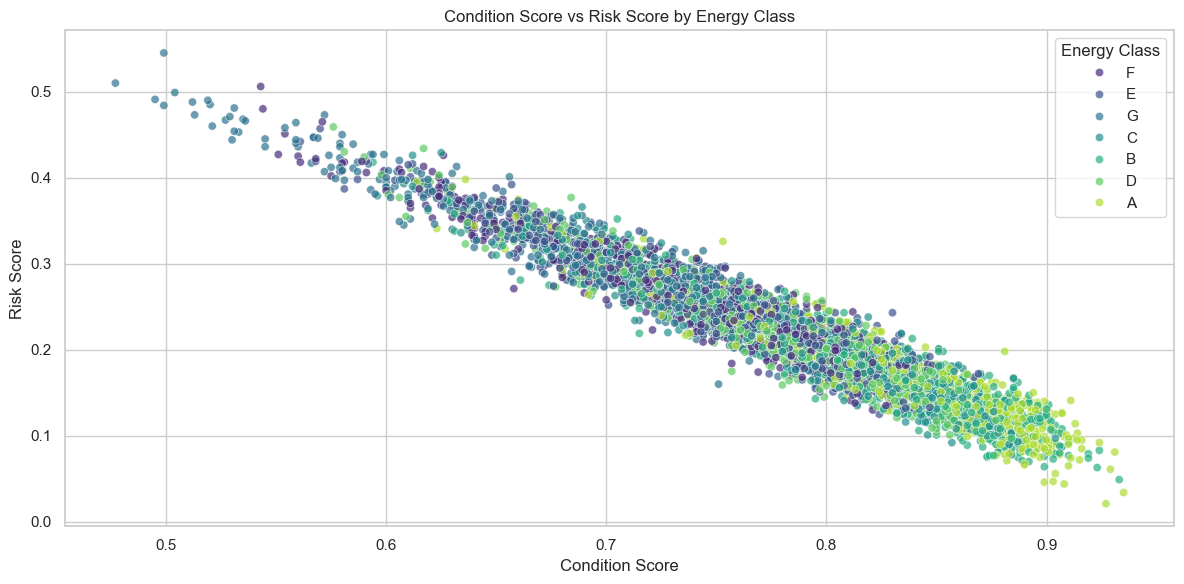

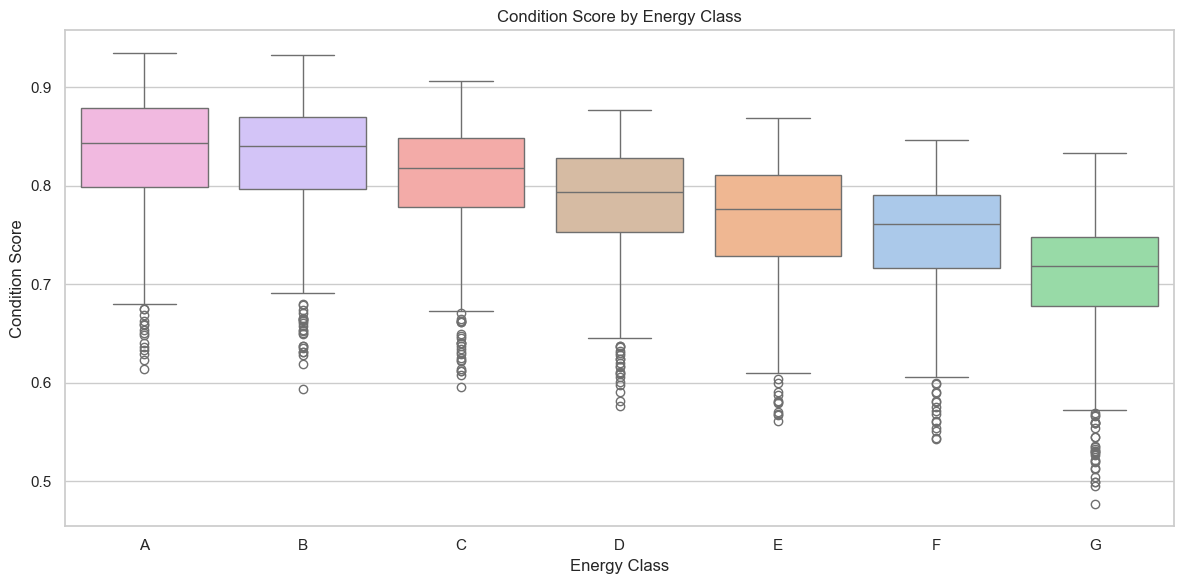

In [12]:
# --- Distribuzioni: size_m2 e valuation_k ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df["size_m2"], kde=True, ax=axes[0], color="steelblue")
axes[0].set_title("Size (m²) Distribution")
axes[0].set_xlabel("Size (m²)")

sns.histplot(df["valuation_k"], kde=True, ax=axes[1], color="salmon")
axes[1].set_title("Valuation (k€) Distribution")
axes[1].set_xlabel("Valuation (k€)")

plt.tight_layout()
plt.show()

# --- Distribuzioni univariate: condition_score e risk_score ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df["condition_score"], kde=True, ax=axes[0], color="green")
axes[0].set_title("Condition Score Distribution")
axes[0].set_xlabel("Condition Score")

sns.histplot(df["risk_score"], kde=True, ax=axes[1], color="darkred")
axes[1].set_title("Risk Score Distribution")
axes[1].set_xlabel("Risk Score")

plt.tight_layout()
plt.show()

# --- Scatterplot: condition vs risk + hue energy_class ---
sns.scatterplot(
    data=df, x="condition_score", y="risk_score",
    hue="energy_class", palette="viridis", alpha=0.7
)
plt.title("Condition Score vs Risk Score by Energy Class")
plt.xlabel("Condition Score")
plt.ylabel("Risk Score")
plt.legend(title="Energy Class")
plt.tight_layout()
plt.show()

# --- Boxplot: condition_score by energy_class ---
sns.boxplot(
    data=df,
    x="energy_class", y="condition_score",
    hue="energy_class",       # assegna hue uguale a x
    order=energy_order,
    palette="pastel",
    legend=False              # evita la legenda duplicata
)
plt.title("Condition Score by Energy Class")
plt.xlabel("Energy Class")
plt.ylabel("Condition Score")
plt.tight_layout()
plt.show()

### Condition and risk

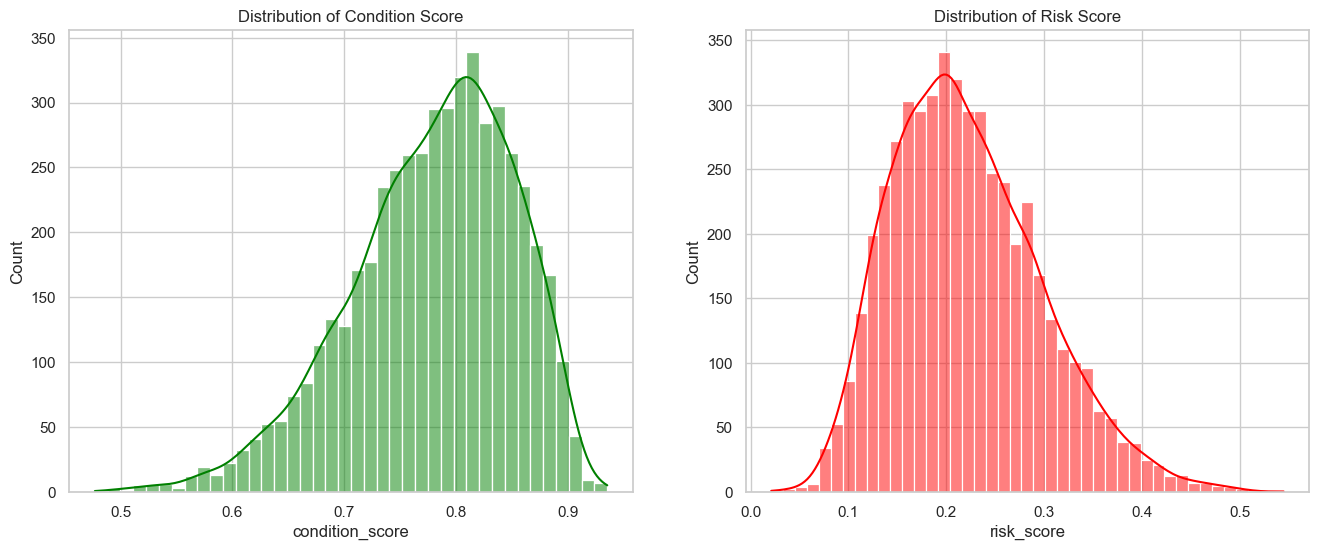

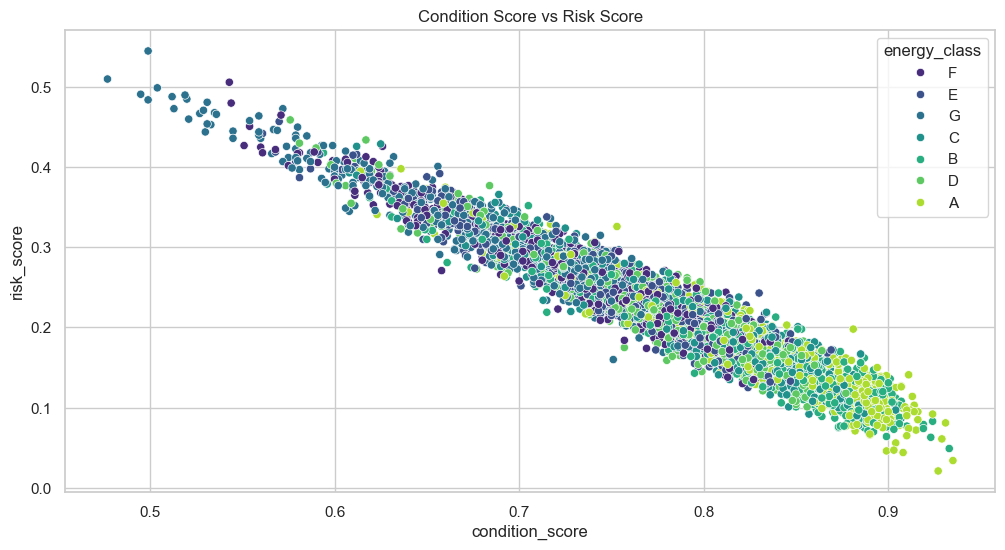

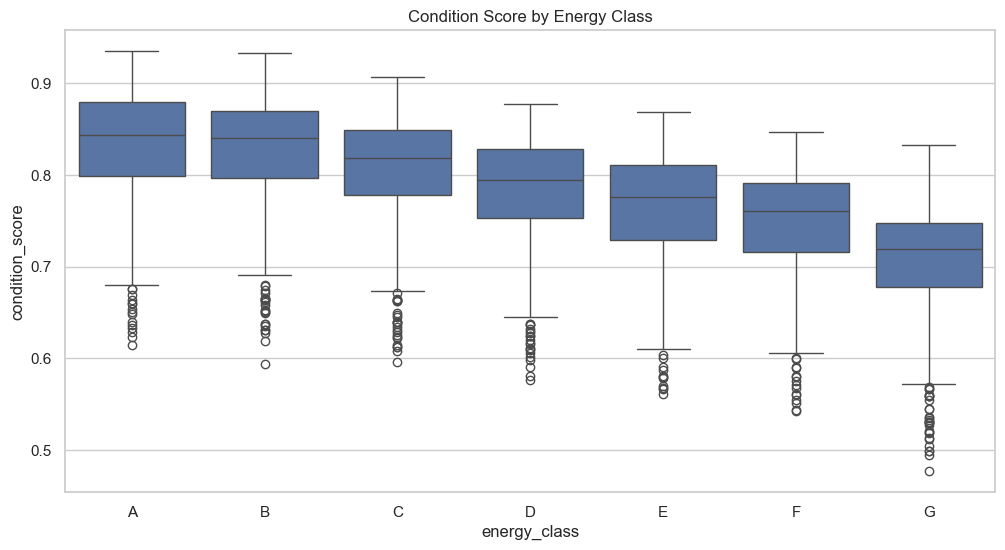

In [13]:
# Distribuzioni univariate
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df["condition_score"], kde=True, ax=axes[0], color="green")
axes[0].set_title("Distribution of Condition Score")

sns.histplot(df["risk_score"], kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Risk Score")
plt.show()

# Scatter: condition vs risk
sns.scatterplot(
    data=df, x="condition_score", y="risk_score",
    hue="energy_class", palette="viridis"
)
plt.title("Condition Score vs Risk Score")
plt.show()

# Boxplot per classe energetica
sns.boxplot(
    data=df, x="energy_class", y="condition_score",
    order=energy_order
)
plt.title("Condition Score by Energy Class")
plt.show()

## 06. Relations

### Technical Overview
Displays inter-feature correlations to assess multicollinearity and feature relationships.

### Implementation Details
- Calculates Pearson correlation matrix for all numeric features
- Masks upper triangle to improve readability
- Uses Seaborn heatmap with annotations

### Purpose
Identifies features strongly correlated with `valuation_k` or others, useful for feature selection.

### Output
Heatmap of lower triangle correlations (with values).

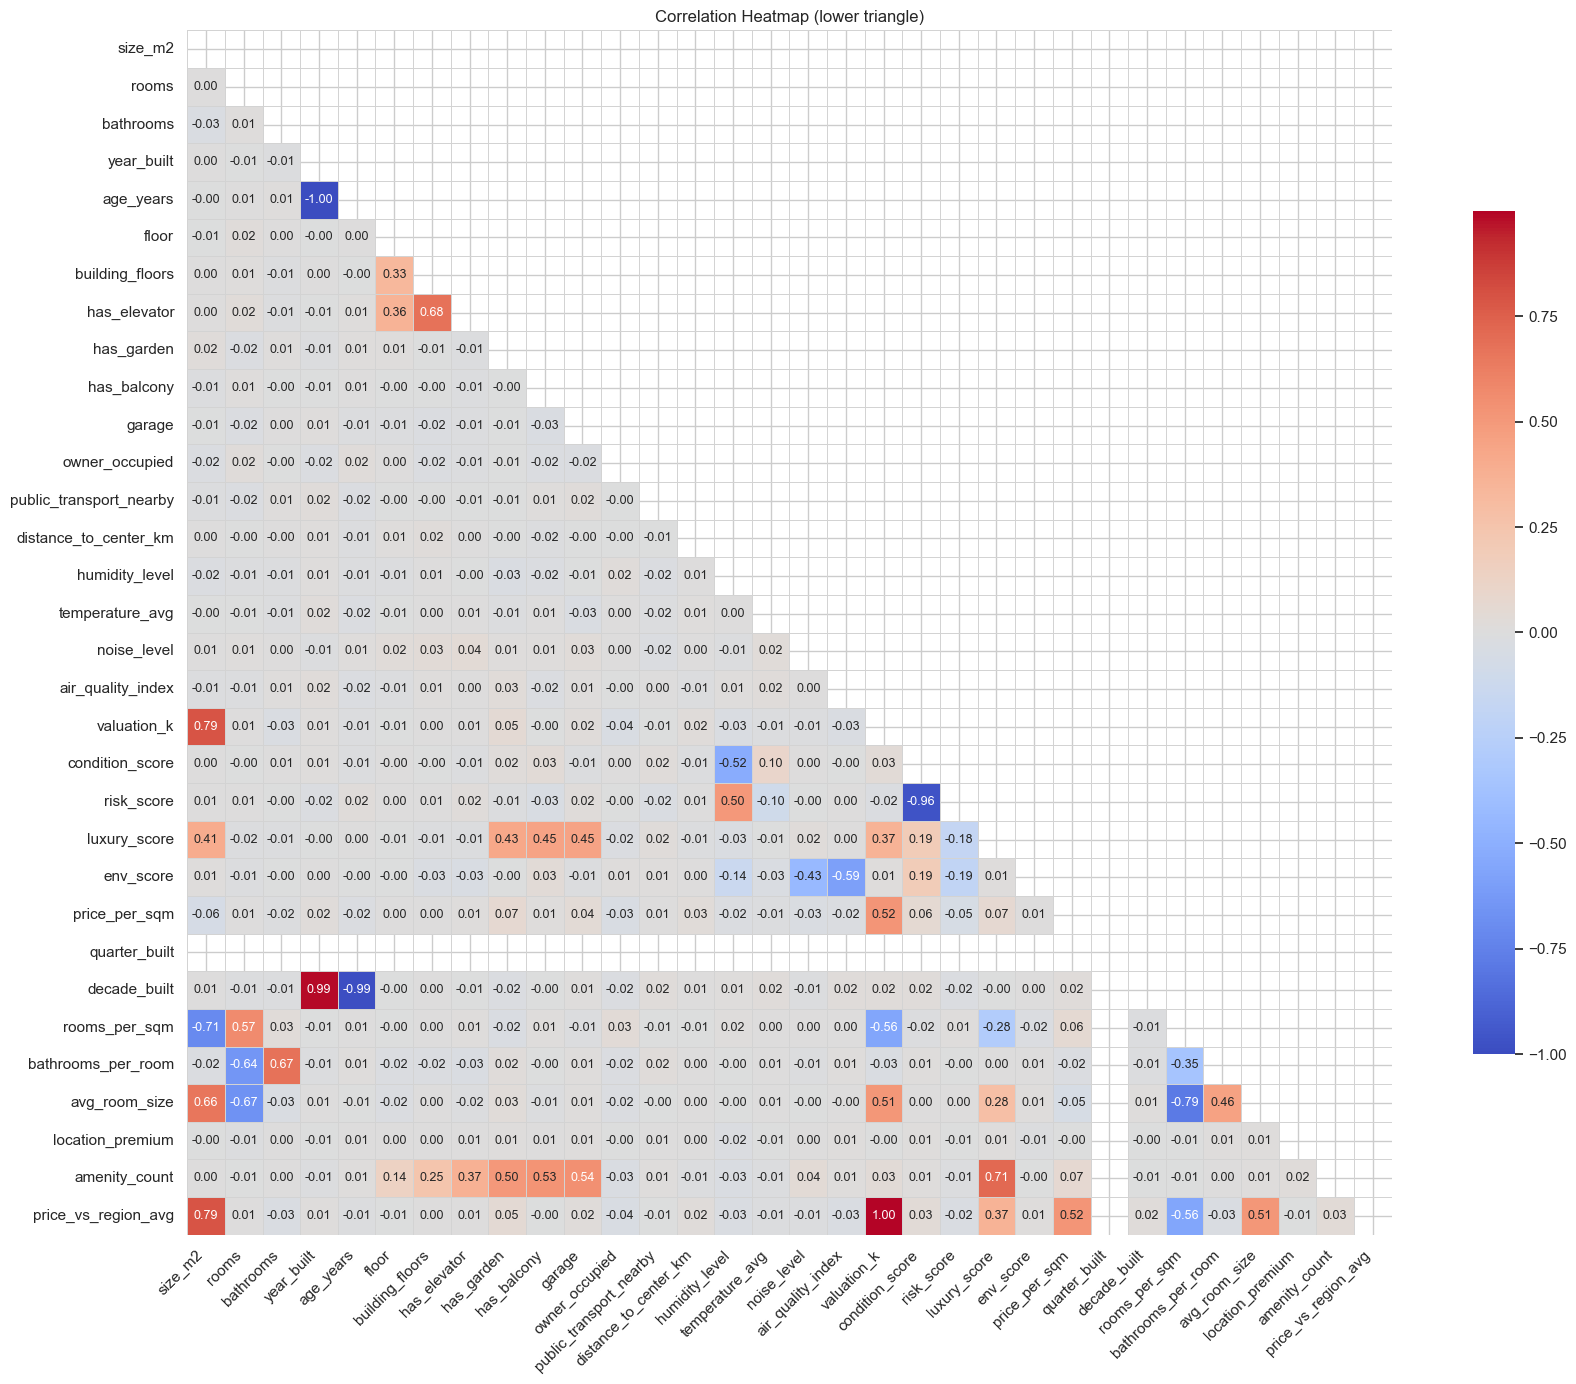

In [21]:
# Calcolo correlazioni numeriche
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

# Heatmap triangolare inferiore
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(18, 14))  # ⬅️ aumenta la dimensione
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7},
    annot_kws={"size": 9},     # ⬅️ font più piccolo
    linewidths=0.5,            # ⬅️ griglia sottile
    linecolor='lightgray'
)
plt.xticks(rotation=45, ha='right')  # ⬅️ migliora leggibilità
plt.yticks(rotation=0)
plt.title("Correlation Heatmap (lower triangle)")
plt.tight_layout()
plt.show()

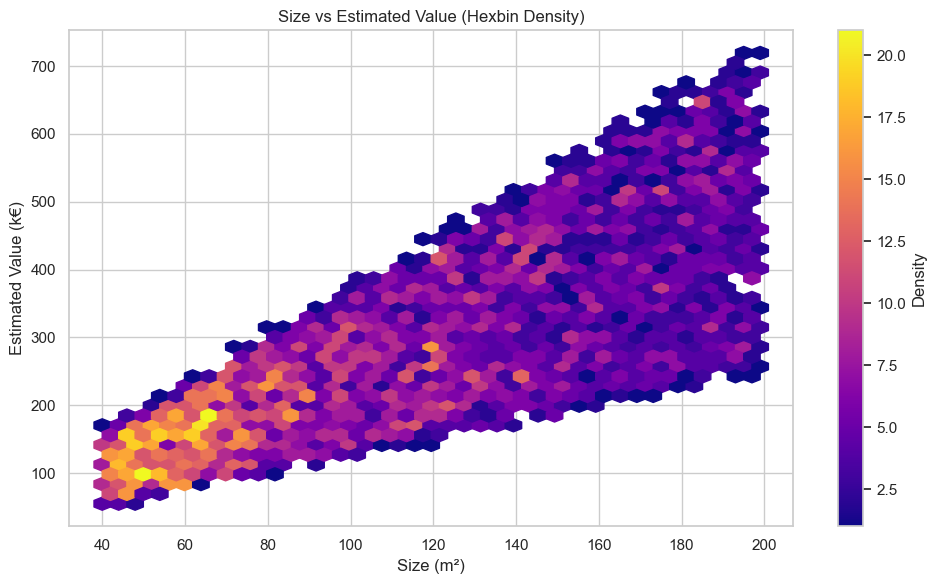

In [22]:
plt.figure(figsize=(10, 6))
plt.hexbin(
    df["size_m2"],
    df["valuation_k"],
    gridsize=40,
    cmap="plasma",
    mincnt=1
)
plt.colorbar(label="Density")
plt.xlabel("Size (m²)")
plt.ylabel("Estimated Value (k€)")
plt.title("Size vs Estimated Value (Hexbin Density)")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

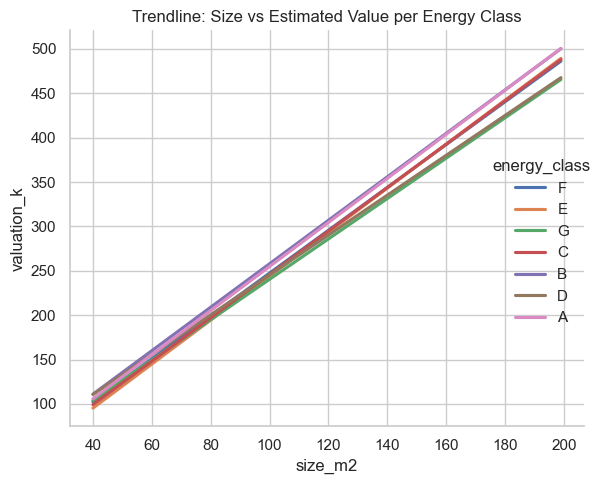

In [23]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=df,
    x="size_m2",
    y="valuation_k",
    hue="energy_class",
    scatter=False,  # niente scatter
    ci=None,
    palette="deep"
)
plt.title("Trendline: Size vs Estimated Value per Energy Class")
plt.tight_layout()
plt.show()

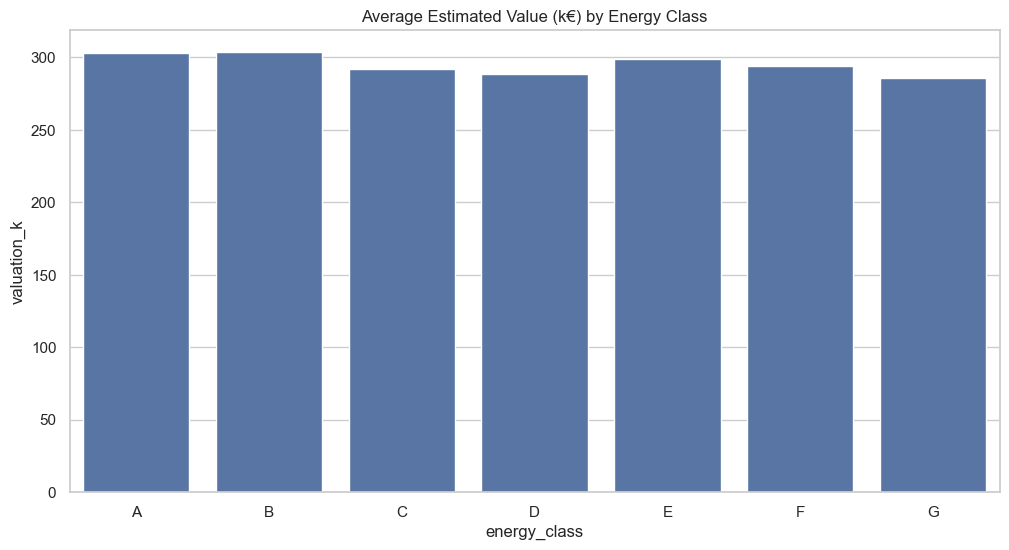

In [24]:
# Valore medio per classe energetica
# Compares average property values across energy efficiency categories
avg_val_by_energy = df.groupby("energy_class")["valuation_k"].mean().reindex(energy_order)
sns.barplot(x=avg_val_by_energy.index, y=avg_val_by_energy.values)
plt.title("Average Estimated Value (k€) by Energy Class")
plt.ylabel("valuation_k")
plt.show()

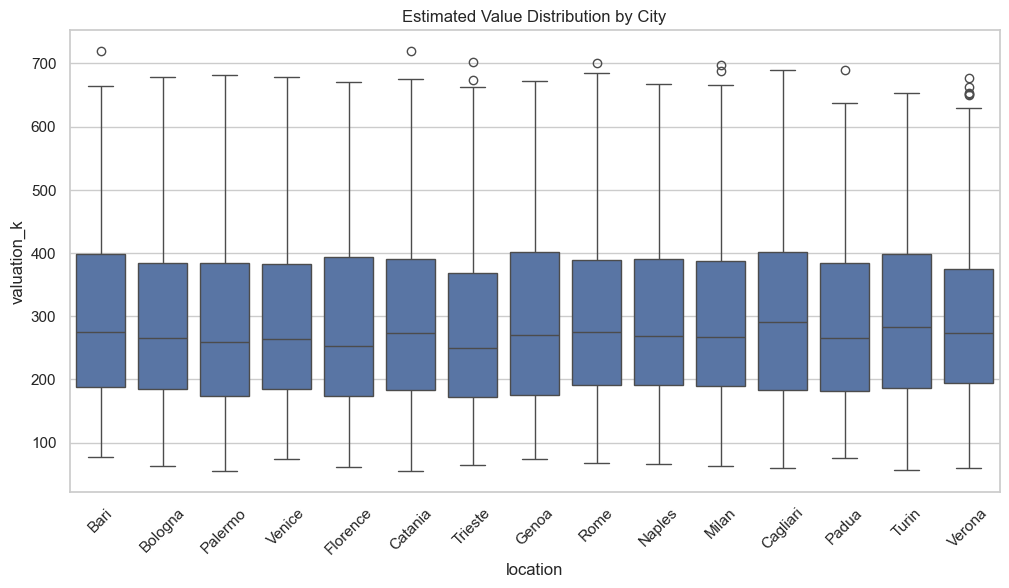

In [25]:
# Boxplot per città
# Visualizes value dispersion across different cities
sns.boxplot(
    data=df, x="location", y="valuation_k", order=df["location"].value_counts().index
)
plt.title("Estimated Value Distribution by City")
plt.xticks(rotation=45)
plt.show()

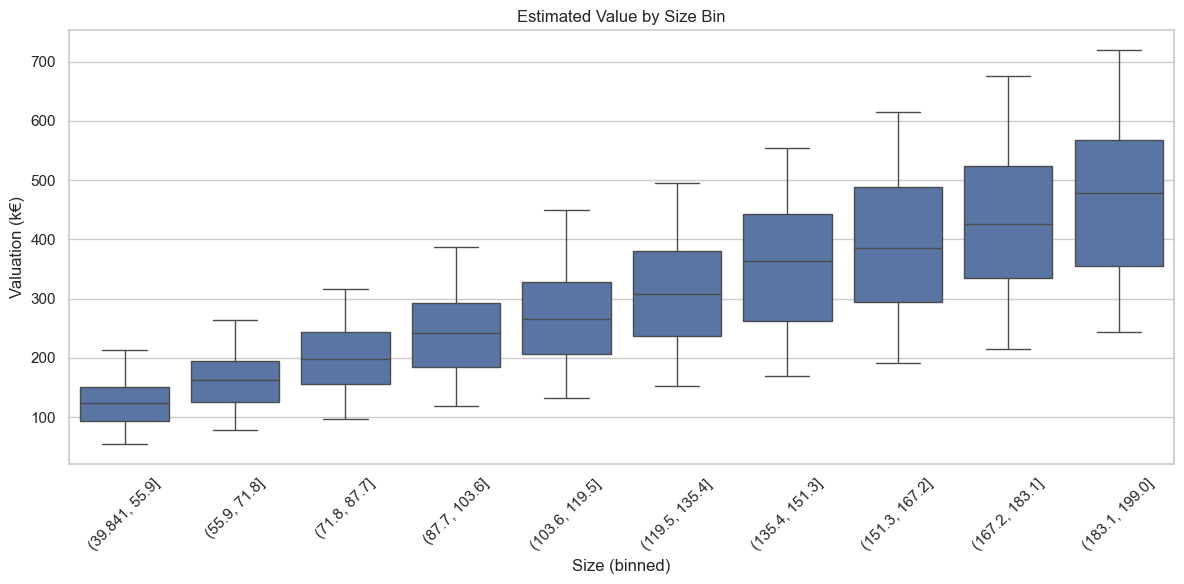

In [26]:
df["size_bin"] = pd.cut(df["size_m2"], bins=10)

# Come varia il valore stimato per range di superficie
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="size_bin", y="valuation_k")
plt.xticks(rotation=45)
plt.title("Estimated Value by Size Bin")
plt.xlabel("Size (binned)")
plt.ylabel("Valuation (k€)")
plt.tight_layout()
plt.show()

### Analisi statistica avanzata

In [40]:
# --- Test di normalità ---
logging.info("📊 Normality Tests (D’Agostino K²):")
for col in ['valuation_k', 'size_m2', 'condition_score']:
    stat, p = stats.normaltest(df[col].dropna())
    logging.info(f"{col}: p={p:.4f} → {'Gaussian ✅' if p > 0.05 else 'Non-Gaussian ❌'}")

# --- Test di indipendenza categoriale (chi² energy vs luxury) ---
if 'energy_class' in df.columns and 'luxury_score' in df.columns:
    df["luxury_category"] = pd.qcut(df["luxury_score"], 3, labels=["low", "mid", "high"])
    contingency = pd.crosstab(df["energy_class"], df["luxury_category"])
    chi2, p_val, _, _ = stats.chi2_contingency(contingency)
    logging.info(f"🔗 Chi² test (energy_class vs luxury_category): p={p_val:.4f} → {'Independent ✅' if p_val > 0.05 else 'Dependent ❌'}")

from sklearn.feature_selection import VarianceThreshold

# --- Step 1: Filtra colonne numeriche ---
num_df = df.select_dtypes(include=[np.number])

# --- Step 2: Rimuovi colonne con varianza nulla ---
selector = VarianceThreshold(threshold=0.0)
X_filtered = selector.fit_transform(num_df)
kept_columns = num_df.columns[selector.get_support()]
num_df_filtered = pd.DataFrame(X_filtered, columns=kept_columns)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vif_data["VIF"] = [
        variance_inflation_factor(num_df_filtered.values, i)
        for i in range(num_df_filtered.shape[1])
    ]

# --- Step 3: Calcolo VIF solo su colonne filtrate ---
vif_data = pd.DataFrame()
vif_data["feature"] = num_df_filtered.columns
vif_data["VIF"] = [
    variance_inflation_factor(num_df_filtered.values, i)
    for i in range(num_df_filtered.shape[1])
]

# --- Output ordinato ---
display(vif_data.sort_values("VIF", ascending=False))

# --- Logging ---
high_vif = vif_data[vif_data["VIF"] > 10]
if not high_vif.empty:
    logging.warning(f"⚠️ Features with high multicollinearity (VIF > 10):\n{high_vif}")
else:
    logging.info("✅ No critical multicollinearity detected (VIF < 10)")

2025-07-29 03:56:21,047 [INFO] 📊 Normality Tests (D’Agostino K²):


AttributeError: 'dict' object has no attribute 'normaltest'

## 07. Temporal analysis

2025-07-29 03:56:24,297 [INFO] 📅 VERIFICATION TIMELINE
2025-07-29 03:56:24,298 [INFO] ==================================================
2025-07-29 03:56:24,299 [INFO] Timezone: UTC
2025-07-29 03:56:24,300 [INFO] Date range: 2025-05-29 01:59:52+00:00 → 2025-07-29 01:40:52+00:00
2025-07-29 03:56:24,302 [INFO] Avg verification age: 30.1 days


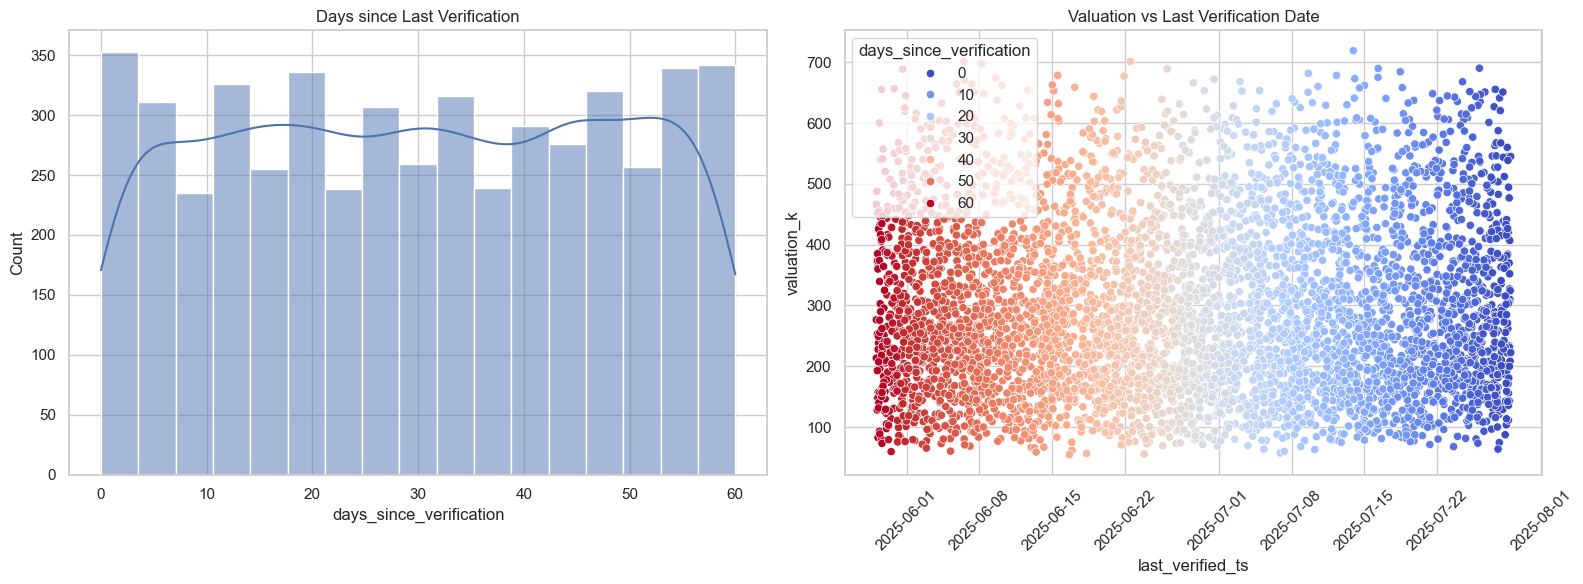

In [41]:
def analyze_verification_timeline(df: pd.DataFrame) -> pd.DataFrame:
    """Analyze verification recency and display valuation vs date."""

    if not pd.api.types.is_datetime64_any_dtype(df["last_verified_ts"]):
        df["last_verified_ts"] = pd.to_datetime(df["last_verified_ts"], errors="coerce")

    df = df.dropna(subset=["last_verified_ts"])

    is_tz_aware = df["last_verified_ts"].dt.tz is not None
    now = pd.Timestamp.now(tz="UTC") if is_tz_aware else pd.Timestamp.now()

    delta = now - df["last_verified_ts"]
    df["days_since_verification"] = delta.dt.days
    df["hours_since_verification"] = delta.dt.total_seconds() / 3600

    logging.info("📅 VERIFICATION TIMELINE")
    logging.info("=" * 50)
    logging.info(f"Timezone: {df['last_verified_ts'].dt.tz}")
    logging.info(f"Date range: {df['last_verified_ts'].min()} → {df['last_verified_ts'].max()}")
    logging.info(f"Avg verification age: {df['days_since_verification'].mean():.1f} days")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.histplot(df["days_since_verification"], kde=True, ax=axes[0])
    axes[0].set_title("Days since Last Verification")

    sns.scatterplot(
        data=df,
        x="last_verified_ts",
        y="valuation_k",
        hue="days_since_verification",
        ax=axes[1],
        palette="coolwarm",
    )
    axes[1].set_title("Valuation vs Last Verification Date")
    axes[1].tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()

    return df

df = analyze_verification_timeline(df)

## 08. Insights

In [29]:
logging.info("🏠 Top 5 by valuation:")
display(
    df[[
        "asset_id", "valuation_k", "size_m2", "energy_class",
        "condition_score", "luxury_score"
    ]]
    .sort_values("valuation_k", ascending=False)
    .head()
)

logging.info("⚠️ Worst 5 by condition_score:")
display(
    df[[
        "asset_id", "valuation_k", "energy_class",
        "condition_score", "risk_score", "humidity_level",
        "env_score"
    ]]
    .sort_values("condition_score")
    .head()
)

logging.info("📍 Mean valuation by location:")
display(df.groupby("location")["valuation_k"].mean().sort_values(ascending=False))

logging.info("📈 Top correlated numeric features to valuation_k:")
corr = df.select_dtypes(include=[np.number]).corr()
print(corr["valuation_k"].sort_values(ascending=False).head(10))

2025-07-29 03:55:36,678 [INFO] 🏠 Top 5 by valuation:


,asset_id,valuation_k,size_m2,energy_class,condition_score,luxury_score
1223,asset_1223,719.27,197,A,0.892,0.8
2914,asset_2914,718.92,198,A,0.873,0.4
128,asset_0128,701.55,192,A,0.891,0.4
1130,asset_1130,701.50,194,A,0.847,0.6
4687,asset_4687,697.69,191,B,0.714,0.6


2025-07-29 03:55:36,691 [INFO] ⚠️ Worst 5 by condition_score:


,asset_id,valuation_k,energy_class,condition_score,risk_score,humidity_level,env_score
3191,asset_3191,135.25,G,0.477,0.510,67.2,0.4
2640,asset_2640,240.17,G,0.495,0.491,68.4,0.0
2965,asset_2965,255.20,G,0.499,0.484,67.5,0.7
1293,asset_1293,302.39,G,0.499,0.545,65.2,0.4
4802,asset_4802,517.15,G,0.504,0.499,69.5,0.3


2025-07-29 03:55:36,705 [INFO] 📍 Mean valuation by location:


location
Turin       307.857850
Cagliari    304.357009
Rome        300.710392
Catania     298.278107
Genoa       297.197741
Bari        296.751728
Padua       296.403323
Verona      296.081538
Venice      295.658963
Naples      293.649366
Milan       291.329021
Palermo     289.964800
Florence    289.803449
Bologna     289.263864
Trieste     279.570178
Name: valuation_k, dtype: float64

2025-07-29 03:55:36,711 [INFO] 📈 Top correlated numeric features to valuation_k:


valuation_k              1.000000
price_vs_region_avg      0.999582
size_m2                  0.789332
price_per_sqm            0.522202
avg_room_size            0.514050
luxury_score             0.365549
has_garden               0.047754
condition_score          0.033607
amenity_count            0.033371
distance_to_center_km    0.021325
Name: valuation_k, dtype: float64


In [30]:
def feature_engineering_analysis(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    logging.info("FEATURE ENGINEERING INSIGHTS")
    logging.info("=" * 50)

    if "price_per_sqm" not in df:
        df["price_per_sqm"] = df["valuation_k"] * 1000 / df["size_m2"]

    if "luxury_score" not in df:
        df["luxury_score"] = (df["has_garden"] + df["has_balcony"] + df["garage"]) / 3

    if "luxury_category" not in df:
        df["luxury_category"] = pd.cut(
            df["luxury_score"], bins=[-0.1, 0, 0.33, 0.66, 1.0],
            labels=["Basic", "Standard", "Premium", "Luxury"]
        )

    if "age_category" not in df:
        df["age_category"] = pd.cut(
            df["age_years"], bins=[0, 10, 30, 50, 100],
            labels=["New", "Modern", "Mature", "Old"]
        )

    if "efficiency_score" not in df:
        df["efficiency_score"] = (
            df["valuation_k"] / df["size_m2"]
        ) * (1 + df["luxury_score"])

    if "env_score" not in df:
        df["env_score"] = (
            (df["humidity_level"] < 60).astype(int) +
            (df["temperature_avg"].between(18, 22)).astype(int) +
            (df["air_quality_index"] < 100).astype(int) +
            (df["noise_level"] < 50).astype(int)
        ) / 4

    if "value_segment" not in df:
        df["value_segment"] = pd.qcut(
            df["valuation_k"], q=4,
            labels=["Budget", "Mid-range", "Premium", "Luxury"]
        )

    # Logging e insight
    logging.info(f"• Avg €/m²: {df['price_per_sqm'].mean():.0f} (min: {df['price_per_sqm'].min():.0f}, max: {df['price_per_sqm'].max():.0f})")
    
    luxury_order = ["Basic", "Standard", "Premium", "Luxury"]
    luxury_counts = df["luxury_category"].value_counts().reindex(luxury_order).fillna(0).astype(int)
    logging.info("• Luxury dist:")
    for cat, count in luxury_counts.items():
        logging.info(f"  • {cat:<9} → {count} units")
    
    logging.info(f"• Env quality - Excellent (>0.75): {(df['env_score'] > 0.75).sum()} | Good (0.5-0.75): {(df['env_score'].between(0.5, 0.75).sum())} | Poor (<0.5): {(df['env_score'] < 0.5).sum()}")

    logging.info("=" * 50)
    logging.info("KEY ASSETS")
    logging.info(f"• Most efficient: {df.nlargest(3, 'efficiency_score')['asset_id'].tolist()}")
    logging.info(f"• Best env: {df.nlargest(3, 'env_score')['asset_id'].tolist()}")
    logging.info(f"• Best €/m²: {df.nsmallest(3, 'price_per_sqm')['asset_id'].tolist()}")

    return df

df = feature_engineering_analysis(df)

2025-07-29 03:55:36,758 [INFO] FEATURE ENGINEERING INSIGHTS
2025-07-29 03:55:36,759 [INFO] ==================================================
2025-07-29 03:55:36,767 [INFO] • Avg €/m²: 2482 (min: 1212, max: 4136)
2025-07-29 03:55:36,770 [INFO] • Luxury dist:
2025-07-29 03:55:36,771 [INFO]   • Basic     → 0 units
2025-07-29 03:55:36,773 [INFO]   • Standard  → 0 units
2025-07-29 03:55:36,774 [INFO]   • Premium   → 0 units
2025-07-29 03:55:36,775 [INFO]   • Luxury    → 0 units
2025-07-29 03:55:36,777 [INFO] • Env quality - Excellent (>0.75): 611 | Good (0.5-0.75): 2025 | Poor (<0.5): 2364
2025-07-29 03:55:36,778 [INFO] ==================================================
2025-07-29 03:55:36,778 [INFO] KEY ASSETS
2025-07-29 03:55:36,807 [INFO] • Most efficient: ['asset_2441', 'asset_1510', 'asset_1072']
2025-07-29 03:55:36,812 [INFO] • Best env: ['asset_0008', 'asset_0019', 'asset_0020']
2025-07-29 03:55:36,816 [INFO] • Best €/m²: ['asset_2251', 'asset_0872', 'asset_1770']


### Anomaly Detection + Isolation Forest

2025-07-29 03:55:37,836 [INFO] 🚨 Detected 250 anomalies (5.00%)
2025-07-29 03:55:37,840 [INFO] 🔍 size_m2: Anomalies +9.1% vs Normal
2025-07-29 03:55:37,845 [INFO] 🔍 valuation_k: Anomalies +24.1% vs Normal
2025-07-29 03:55:37,849 [INFO] 🔍 condition_score: Anomalies -8.5% vs Normal
2025-07-29 03:55:37,854 [INFO] 🔍 risk_score: Anomalies +30.8% vs Normal
2025-07-29 03:55:37,858 [INFO] 🔍 luxury_score: Anomalies +12.7% vs Normal
2025-07-29 03:55:37,863 [INFO] 🔍 env_score: Anomalies -13.7% vs Normal
2025-07-29 03:55:37,869 [INFO] 🔍 price_per_sqm: Anomalies +9.5% vs Normal


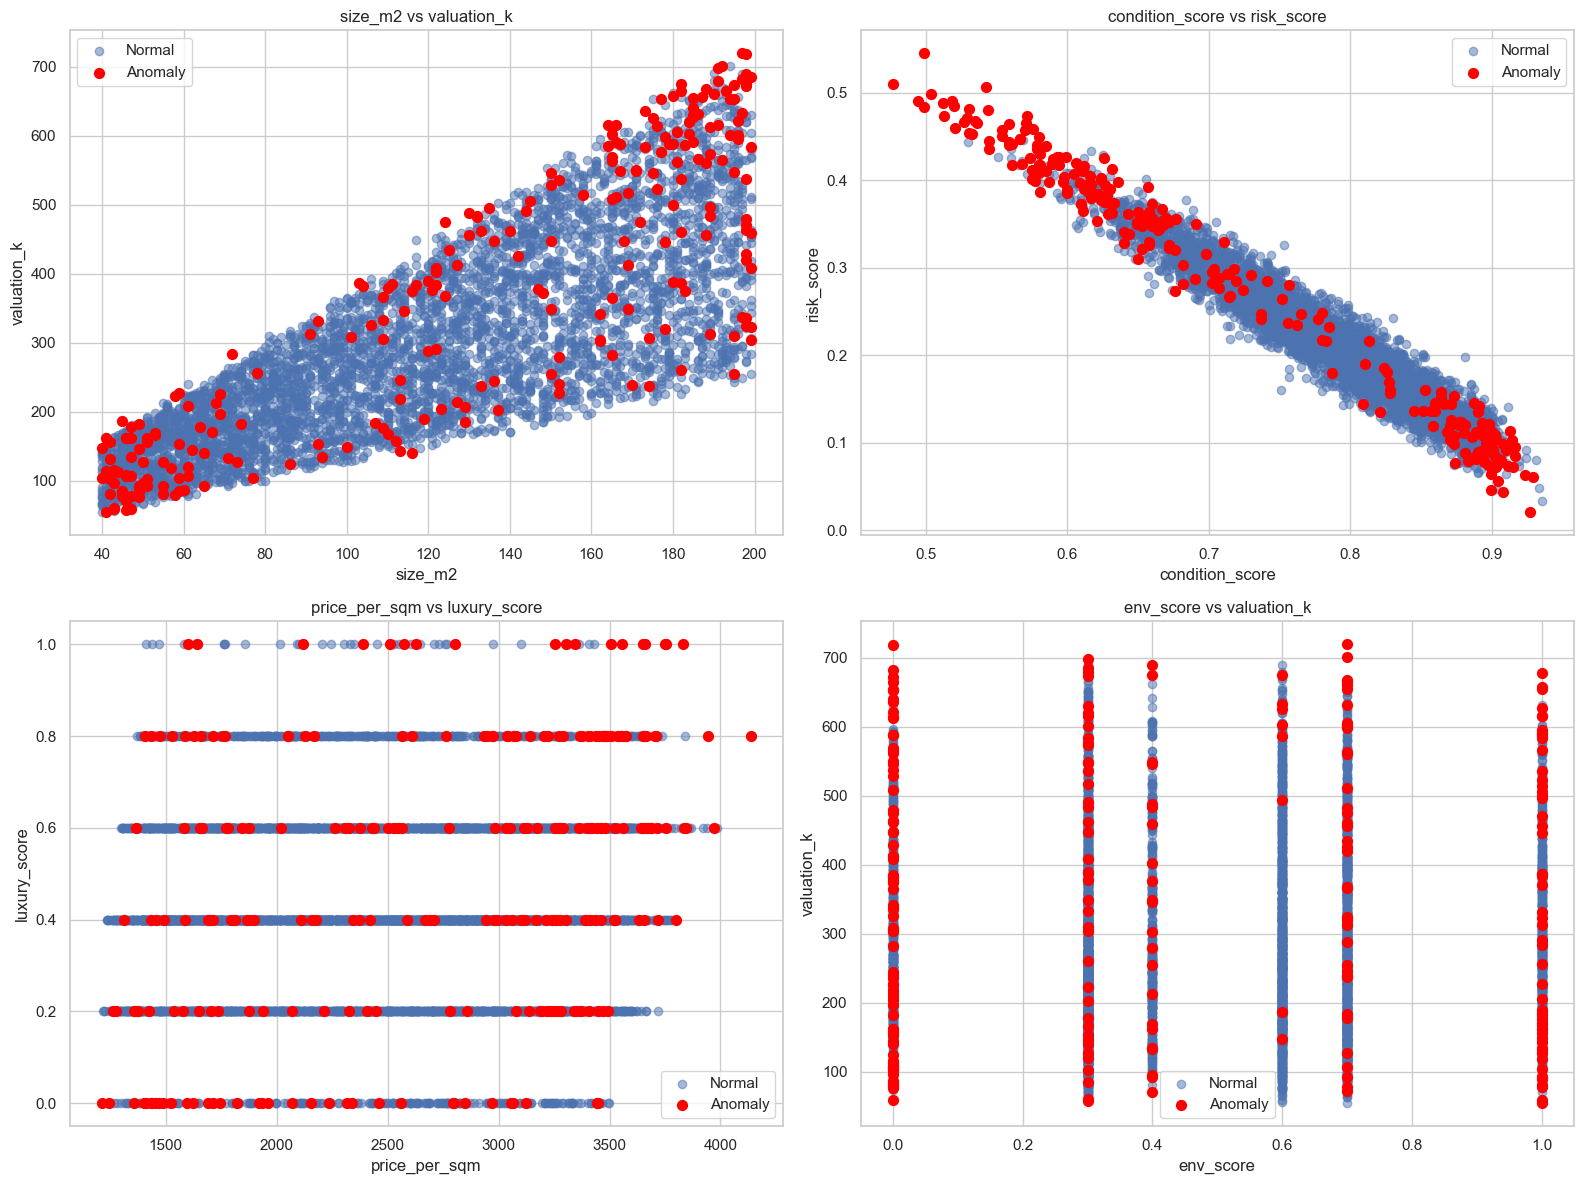

In [31]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# --- Selezione feature rilevanti per anomalie ---
features_for_anomaly = [
    'size_m2', 'valuation_k', 'condition_score', 'risk_score',
    'luxury_score', 'env_score', 'price_per_sqm'
]

# Verifica che tutte siano presenti
features_for_anomaly = [f for f in features_for_anomaly if f in df.columns]

# --- Scaling per detection robusta ---
X = df[features_for_anomaly].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Isolation Forest ---
iso_forest = IsolationForest(
    contamination=0.05,  # 5% di outlier attesi
    random_state=42,
    n_estimators=100
)
df["anomaly_score"] = iso_forest.fit_predict(X_scaled)
df["anomaly_flag"] = df["anomaly_score"] == -1

# --- Log anomalie ---
n_anomalies = df["anomaly_flag"].sum()
logging.info(f"🚨 Detected {n_anomalies} anomalies ({n_anomalies / len(df) * 100:.2f}%)")

# --- Analisi differenziale ---
anomalies = df[df["anomaly_flag"]]
for feature in features_for_anomaly:
    normal_mean = df[~df["anomaly_flag"]][feature].mean()
    anomaly_mean = anomalies[feature].mean()
    diff_pct = (anomaly_mean - normal_mean) / normal_mean * 100
    logging.info(f"🔍 {feature}: Anomalies {diff_pct:+.1f}% vs Normal")

# --- Scatter plot comparativi ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plots = [
    ("size_m2", "valuation_k"),
    ("condition_score", "risk_score"),
    ("price_per_sqm", "luxury_score") if "price_per_sqm" in df.columns else None,
    ("env_score", "valuation_k") if "env_score" in df.columns else None
]

plot_idx = 0
for pair in plots:
    if pair is None: continue
    ax = axes[plot_idx // 2, plot_idx % 2]
    ax.scatter(df[~df["anomaly_flag"]][pair[0]], df[~df["anomaly_flag"]][pair[1]], alpha=0.5, label='Normal')
    ax.scatter(df[df["anomaly_flag"]][pair[0]], df[df["anomaly_flag"]][pair[1]], color='red', s=50, label='Anomaly')
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    ax.set_title(f"{pair[0]} vs {pair[1]}")
    ax.legend()
    plot_idx += 1

plt.tight_layout()
plt.show()

In [32]:
# --- Salva anomalie su file (per auditing o debugging) ---
os.makedirs("../analysis", exist_ok=True)
anomalies_path = "../analysis/anomalies.csv"
df[df["anomaly_flag"]].to_csv(anomalies_path, index=False)
logging.info(f"📝 Saved {df['anomaly_flag'].sum()} anomalies to {anomalies_path}")

2025-07-29 03:55:39,186 [INFO] 📝 Saved 250 anomalies to ../analysis/anomalies.csv


### Feature Importance + Pretraining Analysis


🌲 FEATURE IMPORTANCE & PRE-TRAINING INSIGHTS
🔝 Top Feature Importances (Random Forest):
                 feature  importance
   distance_to_center_km    0.148983
          humidity_level    0.139977
         temperature_avg    0.130085
              risk_score    0.126796
         condition_score    0.119668
hours_since_verification    0.116194
        location_encoded    0.067541
 days_since_verification    0.049887
    energy_class_encoded    0.045857
          region_encoded    0.031887
        location_premium    0.011756
      urban_type_encoded    0.011368


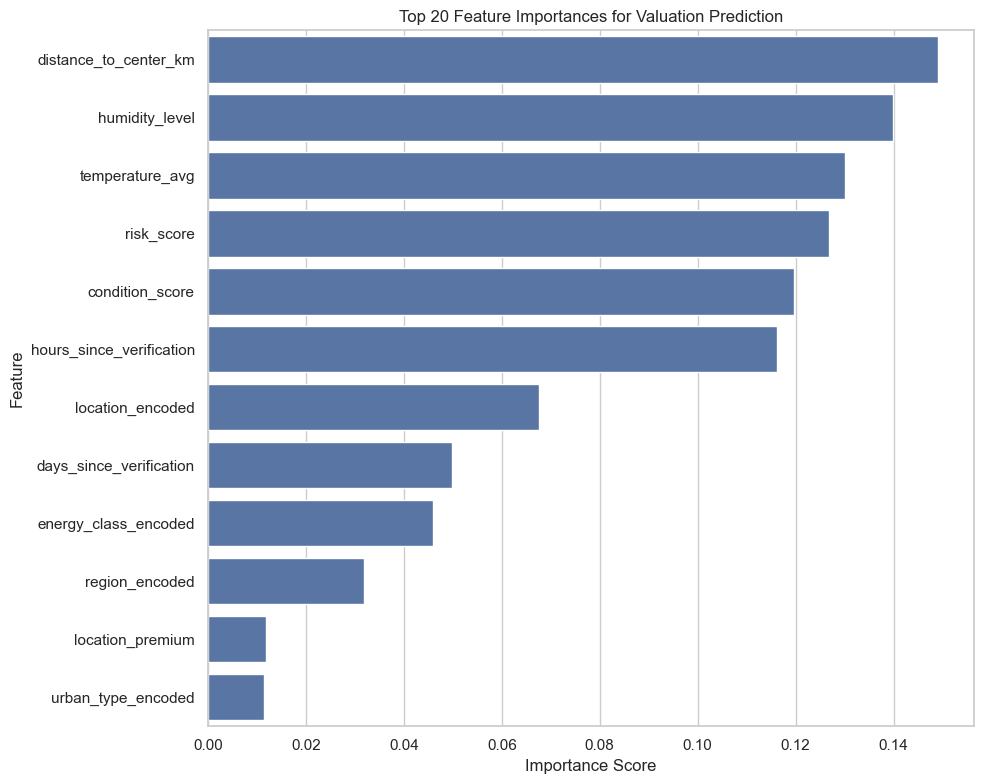

In [33]:
print("\n🌲 FEATURE IMPORTANCE & PRE-TRAINING INSIGHTS")
print("=" * 60)

# --- Copia del dataset ---
df_ml = df.copy()

# --- Encoding categoriche per ML ---
cat_cols = ["location", "energy_class", "urban_type", "region"]
for col in cat_cols:
    if col in df_ml.columns:
        df_ml[f"{col}_encoded"] = LabelEncoder().fit_transform(df_ml[col])

# --- Costruzione lista feature numeriche + encoded ---
feature_cols = [
    col for col in df_ml.columns
    if (
        col not in ["valuation_k", "asset_id", "prediction_ts", "anomaly_flag", "anomaly_score"]
        and (df_ml[col].dtype in [int, float] or col.endswith("_encoded"))
    )
]

proxy_features = ["price_vs_region_avg", "size_m2", "price_per_sqm", "avg_room_size", "rooms_per_sqm", "age_years", "bathrooms_per_room", "luxury_score", "env_score", "efficiency_score"]
feature_cols = [col for col in feature_cols if col not in proxy_features]

# --- Dataset finale per training ---
X = df_ml[feature_cols].fillna(0)
y = df_ml["valuation_k"]

# --- Training modello semplice per stima importanza ---
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# --- Estrazione importanza feature ---
importances = model.feature_importances_
importance_df = (
    pd.DataFrame({"feature": feature_cols, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(20)
)

print("🔝 Top Feature Importances (Random Forest):")
print(importance_df.to_string(index=False))

# --- Visualizzazione ---
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x="importance", y="feature")
plt.title("Top 20 Feature Importances for Valuation Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 10. Outlier Analysis (IQR)

In [42]:
# --- Outlier Detection Function (già ok) ---
def detect_outliers_iqr(df: pd.DataFrame, columns: list[str]) -> dict:
    outliers_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]

        outliers_summary[col] = {
            "count": len(outliers),
            "percentage": round(len(outliers) / len(df) * 100, 2),
            "bounds": (round(lower, 2), round(upper, 2)),
            "records": outliers.copy()
        }

        logging.info(
            f"[OUTLIER] {col}: {len(outliers)} outliers "
            f"({outliers_summary[col]['percentage']}%) "
            f"in bounds {outliers_summary[col]['bounds']}"
        )
    return outliers_summary


# --- Colonne da analizzare ---
numeric_cols = ["size_m2", "valuation_k", "condition_score", "risk_score", "price_per_sqm"]

# --- Lancia analisi ---
outliers = detect_outliers_iqr(df, numeric_cols)

# --- Crea cartella se non esiste ---
os.makedirs("../data/outliers", exist_ok=True)

# --- Salva file per ciascuna metrica ---
for col, statistics in outliers.items():
    path = f"../data/outliers/{col}_outliers.csv"
    statistics["records"].to_csv(path, index=False)

# --- Salva cumulativo ---
all_outlier_indices = pd.concat([statistics["records"] for statistics in outliers.values()]).drop_duplicates()
all_outlier_indices.to_csv("../data/outliers/all_outliers_combined.csv", index=False)

# --- Output riepilogo ---
print("\n📉 OUTLIER ANALYSIS")
print("=" * 50)
for col, statistics in outliers.items():
    print(f"{col}: {statistics['count']} outliers ({statistics['percentage']}%) in bounds {statistics['bounds']}")

2025-07-29 03:59:16,637 [INFO] [OUTLIER] size_m2: 0 outliers (0.0%) in bounds (np.float64(-41.0), np.float64(279.0))
2025-07-29 03:59:16,643 [INFO] [OUTLIER] valuation_k: 4 outliers (0.08%) in bounds (np.float64(-125.79), np.float64(699.53))
2025-07-29 03:59:16,648 [INFO] [OUTLIER] condition_score: 62 outliers (1.24%) in bounds (np.float64(0.59), np.float64(0.98))
2025-07-29 03:59:16,652 [INFO] [OUTLIER] risk_score: 47 outliers (0.94%) in bounds (np.float64(0.01), np.float64(0.43))
2025-07-29 03:59:16,656 [INFO] [OUTLIER] price_per_sqm: 0 outliers (0.0%) in bounds (np.float64(176.38), np.float64(4778.91))



📉 OUTLIER ANALYSIS
size_m2: 0 outliers (0.0%) in bounds (np.float64(-41.0), np.float64(279.0))
valuation_k: 4 outliers (0.08%) in bounds (np.float64(-125.79), np.float64(699.53))
condition_score: 62 outliers (1.24%) in bounds (np.float64(0.59), np.float64(0.98))
risk_score: 47 outliers (0.94%) in bounds (np.float64(0.01), np.float64(0.43))
price_per_sqm: 0 outliers (0.0%) in bounds (np.float64(176.38), np.float64(4778.91))


In [43]:
# Filtra fuori i record anomali da tutte le metriche
outlier_indices = all_outlier_indices.index
df_clean = df.drop(outlier_indices)

# Salva versione "pulita"
df_clean.to_csv("../data/df_cleaned_no_outliers.csv", index=False)
logging.info(f"✅ Clean dataset saved: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")

2025-07-29 03:59:23,808 [INFO] ✅ Clean dataset saved: 4929 rows, 49 columns


## 09. ML Preparation Insights

In [44]:
print("\n📊 ML PREPARATION INSIGHTS")
print("=" * 60)

# --- Correlazioni numeriche col target ---
corr_with_target = (
    df.select_dtypes(include=[np.number])
    .corr()["valuation_k"]
    .drop("valuation_k")
    .abs()
    .sort_values(ascending=False)
)

print("🔝 Top 10 features correlated with `valuation_k`:")
print(corr_with_target.head(10).to_string())

# Focus su alcune feature chiave
print("\n🎯 Correlazioni specifiche:")
for feature in ["luxury_score", "env_score", "price_per_sqm"]:
    if feature in corr_with_target:
        print(f"• {feature}: {corr_with_target[feature]:.3f}")

# Analisi encoding feature categoriche
print("\n🧠 Categorical features encoding strategy:")
categorical_features = ["location", "energy_class", "age_category"]
for feature in categorical_features:
    if feature in df.columns:
        unique_count = df[feature].nunique()
        strategy = "one-hot encoding" if unique_count <= 10 else "target encoding or embedding"
        print(f"• {feature} → {unique_count} unique → {strategy}")

print("=" * 60)


📊 ML PREPARATION INSIGHTS
🔝 Top 10 features correlated with `valuation_k`:
price_vs_region_avg    0.999582
size_m2                0.789332
efficiency_score       0.620018
rooms_per_sqm          0.557301
price_per_sqm          0.522202
avg_room_size          0.514050
luxury_score           0.365549
anomaly_score          0.109548
has_garden             0.047754
owner_occupied         0.035723

🎯 Correlazioni specifiche:
• luxury_score: 0.366
• env_score: 0.014
• price_per_sqm: 0.522

🧠 Categorical features encoding strategy:
• location → 15 unique → target encoding or embedding
• energy_class → 7 unique → one-hot encoding
• age_category → 4 unique → one-hot encoding


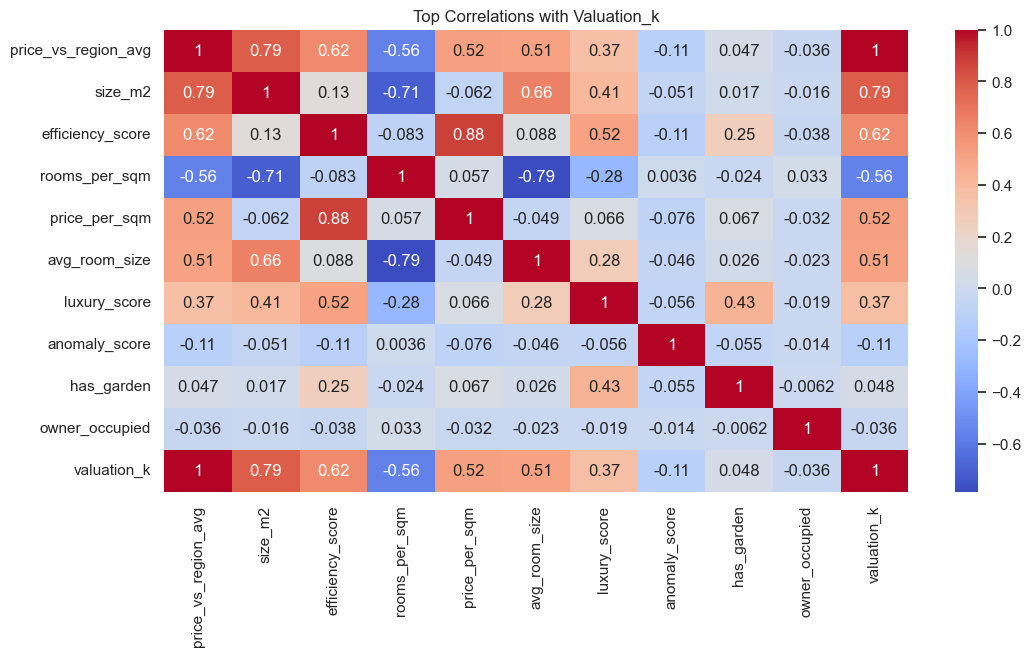

In [45]:
top_corr = corr_with_target.head(10).index.tolist() + ["valuation_k"]
sns.heatmap(df[top_corr].corr(), annot=True, cmap="coolwarm")
plt.title("Top Correlations with Valuation_k")
plt.show()

In [46]:
# Confirms presence of multiple asset types for multi-RWA support
if df["asset_type"].nunique() > 1:
    sns.countplot(data=df, x="asset_type")
    plt.title("Distribution by Asset Type")
    plt.show()
else:
    logging.info("Note: Single asset_type detected ('property'). Structure ready for extensions.")

2025-07-29 03:59:25,902 [INFO] Note: Single asset_type detected ('property'). Structure ready for extensions.


### Multi RWA Analysis

In [47]:
def analyze_asset_type(df: pd.DataFrame, asset_type: str) -> pd.DataFrame:
    subset = df[df["asset_type"] == asset_type]
    logging.info(f"\n🔎 ANALYSIS FOR ASSET_TYPE: {asset_type.upper()}")
    logging.info("=" * 50)
    logging.info(f"Records: {len(subset)}")
    logging.info(f"Date range: {subset['last_verified_ts'].min()} → {subset['last_verified_ts'].max()}")

    if asset_type == "property":
        logging.info(f"Size range: {subset['size_m2'].min()}–{subset['size_m2'].max()} m²")
        logging.info(f"Valuation range: {subset['valuation_k'].min()}–{subset['valuation_k'].max()} k€")

        # Top 3 città per valore medio
        top_locations = (
            subset.groupby("location")["valuation_k"]
            .mean()
            .sort_values(ascending=False)
            .head(3)
        )

        logging.info("Top locations by avg value:")
        for city, val in top_locations.items():
            logging.info(f"• {city:<12} → {val:.2f} k€")

    return subset

for atype in df["asset_type"].unique():
    analyze_asset_type(df, atype)

if df["asset_type"].nunique() == 1:
    print("\n📦 MULTI-RWA READINESS")
    print("=" * 50)
    print("✅ Single asset type detected (property)")
    print("✅ asset_type field present and consistent")
    print("✅ Schema ready for additional asset types")
    print("📋 Next: Add art, greenhouse, warehouse generators")

2025-07-29 03:59:26,800 [INFO] 
🔎 ANALYSIS FOR ASSET_TYPE: PROPERTY
2025-07-29 03:59:26,801 [INFO] ==================================================
2025-07-29 03:59:26,802 [INFO] Records: 5000
2025-07-29 03:59:26,804 [INFO] Date range: 2025-05-29 01:59:52+00:00 → 2025-07-29 01:40:52+00:00
2025-07-29 03:59:26,804 [INFO] Size range: 40–199 m²
2025-07-29 03:59:26,806 [INFO] Valuation range: 54.78–719.27 k€
2025-07-29 03:59:26,809 [INFO] Top locations by avg value:
2025-07-29 03:59:26,809 [INFO] • Turin        → 307.86 k€
2025-07-29 03:59:26,810 [INFO] • Cagliari     → 304.36 k€
2025-07-29 03:59:26,811 [INFO] • Rome         → 300.71 k€



📦 MULTI-RWA READINESS
✅ Single asset type detected (property)
✅ asset_type field present and consistent
✅ Schema ready for additional asset types
📋 Next: Add art, greenhouse, warehouse generators
